# Address Similarity Analysis Using TF-IDF Vectorization and Cosine Similarity

## Introduction
In this notebook, we demonstrate how to use TF-IDF vectorization and cosine similarity to identify the original forms of shortened addresses. This approach is useful in scenarios where addresses may have been truncated or altered or there is misspelling, and we need to find their closest matches from a reference dataset.

## Data Loading
We start by loading the original and modified addresses from JSON files.

In [6]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the original and modified addresses
with open('../data/original_all_addresses.json', 'r') as file:
    all_addresses = json.load(file)

with open('../data/modified_all_addresses.json', 'r') as file:
    modified_addresses = json.load(file)

# Convert the list of addresses to DataFrame
df_all_addresses = pd.DataFrame(all_addresses, columns=['address'])
df_modified_addresses = pd.DataFrame(modified_addresses, columns=['address'])

## TF-IDF Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) vectorization converts text data into numerical representations. Each address is transformed into a vector that reflects the importance of each word in the context of the entire dataset.

In [7]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the addresses with TF-IDF Vectorizer
tfidf_all = vectorizer.fit_transform(df_all_addresses['address'])
tfidf_changed = vectorizer.transform(df_modified_addresses['address'])

## Cosine Similarity
Cosine similarity measures the cosine of the angle between two vectors. It is used to determine the similarity between two TF-IDF vectors. A cosine similarity of 1 indicates identical vectors, while 0 indicates orthogonal (completely different) vectors.

In [8]:
# Calculate cosine similarity between the shortened and original addresses
cosine_similarities = cosine_similarity(tfidf_changed, tfidf_all)

## Matching Shortened Addresses to Original Addresses
We define a function to find the most similar original address for each shortened address based on the highest cosine similarity.

In [9]:
# Function to find the most similar original address for each shortened address
def find_most_similar_address(similarities, original_addresses):
    most_similar = []
    for i in range(similarities.shape[0]):
        most_similar_idx = similarities[i].argmax()
        most_similar.append(original_addresses[most_similar_idx])
    return most_similar

# Find the most similar original addresses
most_similar_addresses = find_most_similar_address(cosine_similarities, df_all_addresses['address'])

## Results
We compare the shortened addresses with their most similar original addresses. Only those addresses that were modified (shortened) are included in the results.

In [10]:
# Create a DataFrame to show the results
df_results = pd.DataFrame({
    'Shortened Address': df_modified_addresses['address'],
    'Most Similar Original Address': most_similar_addresses
})

# Filter out the addresses that were not changed
df_filtered_results = df_results[df_results['Shortened Address'] != df_results['Most Similar Original Address']]

df_filtered_results.to_json('../data/similar_addresses.json', orient='records', lines=True)

# Display the results
df_filtered_results.head()

#Todo: add an accuracy measure

,Shortened Address,Most Similar Original Address
17,5461 Wst Shades Vlley Drve,5461 West Shades Valley Drive
21,3729 East Mission Bulevard,3729 East Mission Boulevard
38,802 Madisn Stret Northwest,802 Madison Street Northwest
39,2811 Bttery Plac Northwest,2811 Battery Place Northwest
50,1508 Msschstts vn Sotheast,1508 Massachusetts Avenue Southeast


## Visualization
To better understand the distribution of address lengths and the impact of shortening, we plot histograms of the lengths of the original and modified addresses.

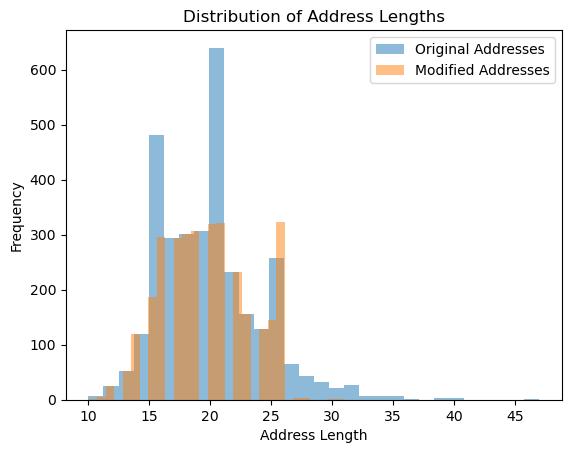

In [12]:
import matplotlib.pyplot as plt

# Plot histogram of original address lengths
df_all_addresses['length'] = df_all_addresses['address'].apply(len)
plt.hist(df_all_addresses['length'], bins=30, alpha=0.5, label='Original Addresses')

# Plot histogram of modified address lengths
df_modified_addresses['length'] = df_modified_addresses['address'].apply(len)
plt.hist(df_modified_addresses['length'], bins=30, alpha=0.5, label='Modified Addresses')

plt.xlabel('Address Length')
plt.ylabel('Frequency')
plt.title('Distribution of Address Lengths')
plt.legend()
plt.show()

## Accuracy Measure
Finally, we calculate an accuracy measure to evaluate how well the cosine similarity method matched the shortened addresses to their original forms.

In [13]:
#ToDo: Accuracy Measure

## Conclusion
In this notebook, we demonstrated how to use TF-IDF vectorization and cosine similarity to find the most similar original addresses for shortened addresses. This method can be useful in various data cleaning and preprocessing tasks where maintaining the integrity of textual data is crucial.